In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCH = 20
BATCH_SIZE = 32
print(DEVICE)

cuda


In [3]:
np_x = np.load('./data_feature_all_hour_new.npy').astype(np.float32)
np_y = np.load('./data_feature_all_hour_target.npy').astype(np.float32)
print(np_x.shape)
print(np_y.shape)
train_spilt_index = int(np_x.shape[0] * 0.8)
train_dataset = TensorDataset(torch.from_numpy(np_x[:train_spilt_index]), torch.from_numpy(np_y[:train_spilt_index].reshape(-1,1)))
test_dataset = TensorDataset(torch.from_numpy(np_x[train_spilt_index:]), torch.from_numpy(np_y[train_spilt_index:].reshape(-1,1)))
trainLoader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE)
testLoader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE)

(3768, 48, 184)
(3768,)


In [4]:
class TransformerBlock(torch.nn.Module):

    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1) -> None:
        super(TransformerBlock, self).__init__()
        self.attn = torch.nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads, batch_first = True)
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, ff_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = torch.nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout = torch.nn.Dropout(rate)
    def forward(self, inputs):
        attn_output, attn_score = self.attn(inputs, inputs, inputs)
        attn_output = self.dropout(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output)
        return self.layernorm2(ffn_output), attn_score

In [5]:
it = iter(trainLoader)
x, y = next(it)

In [6]:
class MedicModel(torch.nn.Module):

    def __init__(self) -> None:
        super(MedicModel, self).__init__()
        self.batch_norm = torch.nn.BatchNorm1d(48)
        self.norm1 = torch.nn.LayerNorm(184)
        self.norm2 = torch.nn.LayerNorm(256)
        self.norm3 = torch.nn.LayerNorm(256)
        self.lstm_256 = torch.nn.LSTM(184, 256, batch_first = True)
        self.lstm_256_256 = torch.nn.LSTM(256, 256, batch_first = True)
        # self.trans = TransformerBlock(256, 64, 184)
   
        self.linear_i = torch.nn.Linear(48 * 256, 60)
        self.linear_o = torch.nn.Linear(60, 1)

    def forward(self,x):
        h = self.batch_norm(x)
        h = self.norm1(h)
        h, (h_i, c_i) = self.lstm_256(h)
        h = torch.tanh(h)
        h_i, c_i = torch.tanh(h_i), torch.tanh(c_i)
        h = self.norm2(h)
        h_i, c_i = self.norm2(h_i), self.norm2(c_i)
        h, (_, _) = self.lstm_256_256(h, (h_i, c_i))
        h = torch.tanh(h)
        h = self.norm3(h)
        
        # atten_out, s = self.trans(h)
        # h = torch.tanh(h)
        h = torch.flatten(h, start_dim=1)
        h = self.linear_i(h)
        h = torch.sigmoid(h)
        h = self.linear_o(h)
        return h


In [7]:
model = MedicModel().cuda()
opti = torch.optim.Adam(model.parameters(), weight_decay=1e-2)
loss_fn = torch.nn.BCEWithLogitsLoss()
train_losses = []
test_losses = []

In [8]:
for epoch in tqdm(range(EPOCH)):
    trainTloss = 0.
    testTloss = 0.
    for x, y in trainLoader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opti.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
        trainTloss += loss.item()
    with torch.no_grad():
        for x, y in testLoader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            loss = loss_fn(pred, y)
            testTloss += loss.item()
    train_losses.append(trainTloss / (len(trainLoader.dataset)//BATCH_SIZE))
    test_losses.append(testTloss / (len(testLoader.dataset)//BATCH_SIZE))


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


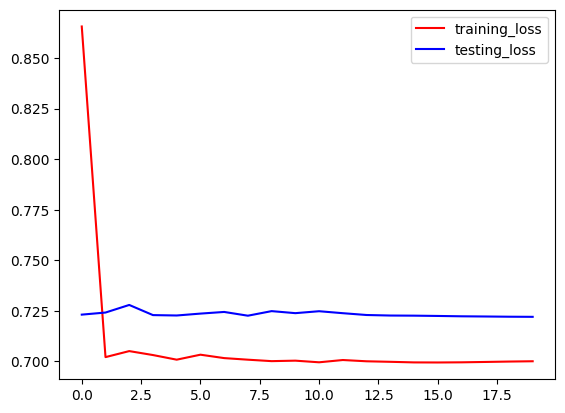

In [9]:
epochs = [ep for ep in range(EPOCH)]
plt.plot(epochs, train_losses, label = "training_loss", color = 'r')
plt.plot(epochs, test_losses, label = "testing_loss", color = 'b')
plt.legend()
plt.show()

In [10]:
model.eval()

MedicModel(
  (batch_norm): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm1): LayerNorm((184,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lstm_256): LSTM(184, 256, batch_first=True)
  (lstm_256_256): LSTM(256, 256, batch_first=True)
  (trans): TransformerBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=256, out_features=184, bias=True)
      (1): ReLU()
      (2): Linear(in_features=184, out_features=256, bias=True)
    )
    (layernorm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
    (layernorm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear_i): Linear(in_features=12288, out_features=60, bias=True)


In [11]:
correct = 0.
for x, y in trainLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(trainLoader.dataset))

0.5298606502986065


In [12]:
correct = 0.
for x, y in testLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(testLoader.dataset))

0.5291777188328912


In [13]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [14]:
with torch.no_grad():
    x, y = trainLoader.dataset[:]
    x = x.to(DEVICE)
    pred = torch.sigmoid(model(x))
    pred = pred.cpu()
    fpr, tpr, thr = roc_curve(y_true = y, y_score=pred)
    print(fpr)
    print(tpr)
    print(thr)

[0.         0.         0.         0.00125235 0.00125235 0.00187852
 0.00688791 0.01377583 0.02191609 0.02316844 0.02755166 0.02943018
 0.04070131 0.0482154  0.06386976 0.0651221  0.06825297 0.07889793
 0.08891672 0.09455229 0.12523482 0.13650595 0.17031935 0.17845961
 0.20914214 0.24483406 0.30870382 0.34189105 0.45710708 0.53663118
 0.63306199 0.64433312 0.92172824 1.        ]
[0.         0.00141143 0.00282287 0.0084686  0.00988003 0.01129146
 0.01552576 0.02399435 0.02752294 0.02893437 0.03316867 0.03740296
 0.04446013 0.04587156 0.05575159 0.05928017 0.07268878 0.08468596
 0.1037403  0.11503176 0.14749471 0.1601976  0.21171489 0.2251235
 0.25899788 0.30275229 0.36485533 0.3853211  0.50317572 0.54340155
 0.64008469 0.66196189 0.92307692 1.        ]
[1.453241   0.45324096 0.4532409  0.4532408  0.45324075 0.4532407
 0.4532406  0.45324057 0.4532405  0.45324045 0.45324042 0.45324036
 0.4532403  0.45324028 0.45324022 0.45324016 0.45324013 0.45324007
 0.45324    0.45323998 0.45323992 0.453

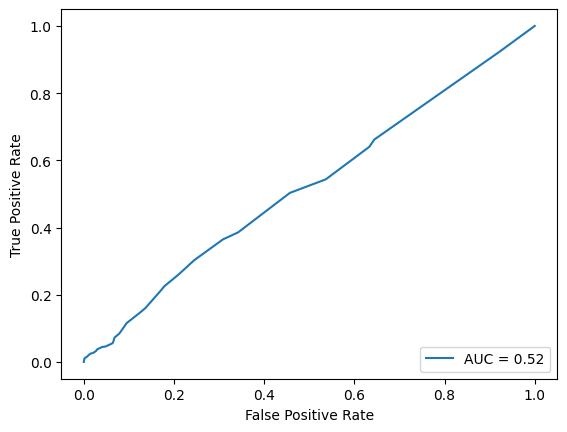

In [15]:
roc_auc = auc(fpr, tpr)
result = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
result.plot()

In [16]:
with torch.no_grad():
    x, y = testLoader.dataset[:]
    x = x.to(DEVICE)
    pred = torch.sigmoid(model(x))
    pred = pred.cpu()
    fpr, tpr, thr = roc_curve(y_true = y, y_score=pred)
    print(fpr)
    print(tpr)
    print(thr)

[0. 1.]
[0. 1.]
[1.4532393 0.4532393]


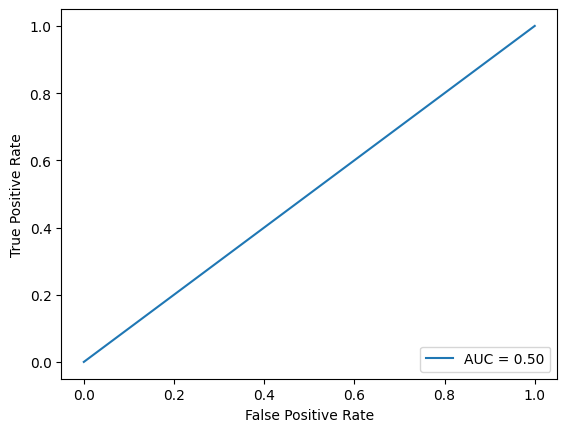

In [17]:
roc_auc = auc(fpr, tpr)
result = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
result.plot()